<a href="https://colab.research.google.com/github/ladiaJeong/-01-classification/blob/master/%5B11%5D_CIFAR_10_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EC%83%9D%EC%84%B1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### STEP 1. 작업환경 구성하기

In [ ]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline  

### STEP 2. 데이터셋 구성하기

In [ ]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [ ]:
# 모델 크기 확인
print("max pixel:", np.amax(train_x)) 
print("min pixel:", np.amin(train_x))

max pixel: 255
min pixel: 0


In [ ]:
#정규화(중간값을 0으로 맞춤 )
train_x = train_x.astype('float32')
train_x = (train_x - 127.5) / 127.5 

print("max pixel:", np.amax(train_x))
print("min pixel:", np.amin(train_x))

max pixel: 1.0
min pixel: -1.0


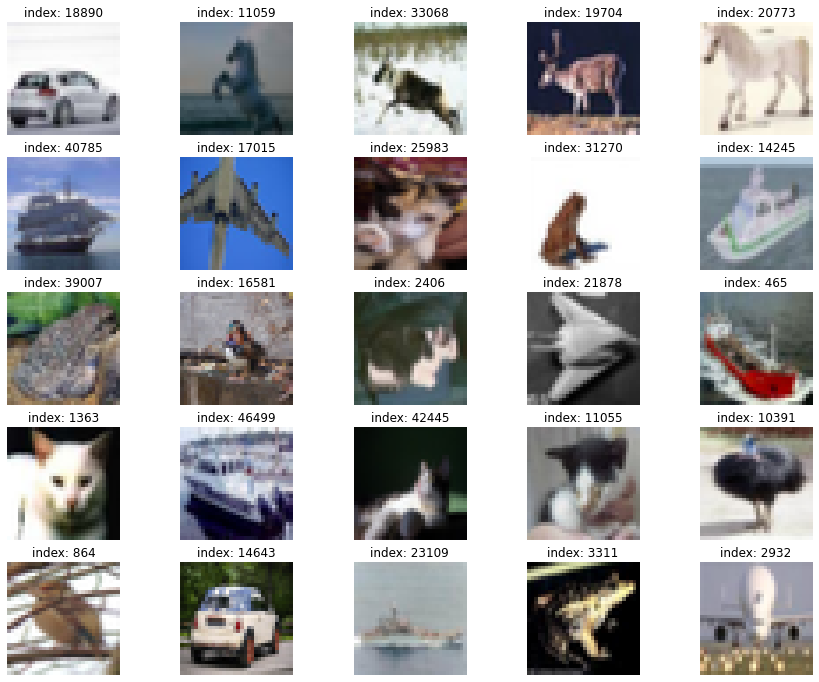

In [ ]:
#전체프레임 설정하고 25개의 이미지 미리보기

plt.figure(figsize=(15, 12))

for i in range(25):
    rn = np.random.randint(train_x.shape[0])
    plt.subplot(5, 5, i+1)
    Image = np.clip(train_x[rn], 0, 1)
#     plt.imshow(Image.reshape(32, 32, 3))
    plt.imshow((train_x[rn] + 1)/2.0)
    plt.title(f'index: {rn}')
    plt.axis('off')
    
plt.show()

In [ ]:
# 전체 사이즈를 50000으로 설정 서플 함수가 섞어서 모델에 넣어줌
BUFFER_SIZE = 50000 # 데이터가 잘 섞이려면 버퍼사이즈는 총 데이터사이즈와 같거나 큰것이 좋다
BATCH_SIZE = 256 # 한번에 학습할 데이터의 양

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

### STEP 3. 생성자 모델 구현하기

In [ ]:
def make_generator_model(momentum=0.9, alpha=0.2):
    dropout = 0.4
   
# Start
    model = tf.keras.Sequential()

# First: Dense layer
    model.add(layers.Dense(4*4*512, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
# second: Reshape layer    
    model.add(layers.Reshape(( 4, 4, 512)))
    model.add(layers.Dropout(dropout))
    
# Third: Conv2DTranspose layer  
    model.add(layers.Conv2DTranspose(256, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 8, 8, 256)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))
    
# Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 16, 16, 128)
    model.add(layers.BatchNormalization(momentum=momentum))
    model.add(layers.LeakyReLU(alpha=alpha))

# Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))
    assert model.output_shape == (None, 32, 32, 3)
    return model

In [ ]:
generator = make_generator_model()

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8192)              819200    
_________________________________________________________________
batch_normalization_9 (Batch (None, 8192)              32768     
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8192)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 4, 4, 512)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 512)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 256)         3276800   
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 256)        

In [ ]:
# shape=(1, 100)의 형상을 가지는 랜덤 노이즈 벡터를 생성
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

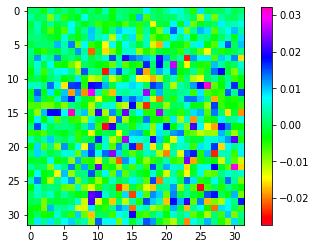

In [ ]:
# 학습이 아니기때문에 False값을 주었다
plt.imshow(generated_image[0, :, :, 0], cmap ='gist_rainbow')
plt.colorbar()
plt.show()

### STEP 4. 판별자 모델 구현하기

In [ ]:
def make_discriminator_model(alpha=0.2):
    dropout = 0.4
    
    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dropout))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=alpha))
    model.add(layers.Dropout(dropout))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    

    return model

In [ ]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 128)       9728      
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 256)         819456    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8, 8, 256)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 8, 8, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)            

In [ ]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00155776]], dtype=float32)>

### STEP 5. 손실함수와 최적화 함수 구현하기

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 생성자 손실 함수
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 판별자 손실 함수 
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
# zeros_like는 특정 벡터와 동일한 크기, 값은 0으로 채워진 벡터


def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [ ]:
# 최적화 함수(학습을 따로 진행함)

generator_optimizer = tf.keras.optimizers.Adam(4e-4, beta_1=0.5)#생성자
discriminator_optimizer = tf.keras.optimizers.Adam(8e-4, beta_1=0.5)#핀별자

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

### STEP 6. 훈련과정 상세 기능 구현하기

In [ ]:
# 1개 미니배치의 훈련 과정을 처리하는 train_step() 함수를 구현해 봅시다.

@tf.function  ## 텐서플로우 function을 사용함으로써 Tensorflow의 graph 노드가 될 수 있는 타입으로 자동변환
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [ ]:
# 예측 이미지를 파일에 저장
# gif 파일 생성을 위함
#16개의 고정된 seed를 입력으로 하여 훈련 과정 동안 생성한 이미지를 시각화하는 generate_and_save_images() 함수를 구현해 봅시다.

def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)

    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i] + 1)/2.0)
        plt.axis('off')
        
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(os.getenv('HOME'), epoch, it))

    plt.show()

In [ ]:
# training_history 생성
# 훈련 epoch마다 생성자/판별자의 loss 및 판별자의 실제/생성(real/fake) 이미지 판별 accuracy 히스토리(history)를 그래프로 시각화하는 draw_train_history() 함수를 구현해 봅시다.
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('{}/aiffel/dcgan_newimage/cifar10/training_history/train_history_{:04d}.png'
                    .format(os.getenv('HOME'), epoch))
    plt.show()

In [ ]:
# 체크 포인트 만들기
#training_checkpoints 디렉토리에 몇 epoch마다 모델을 저장하는 checkpoint 모듈을 설정해 봅시다.

checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### STEP 7. 학습 과정 진행하기

In [ ]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [ ]:
save_every = 5
EPOCHS = 50

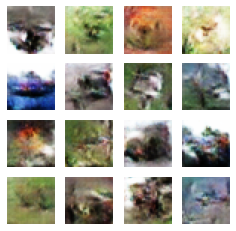

Time for training : 2086 sec


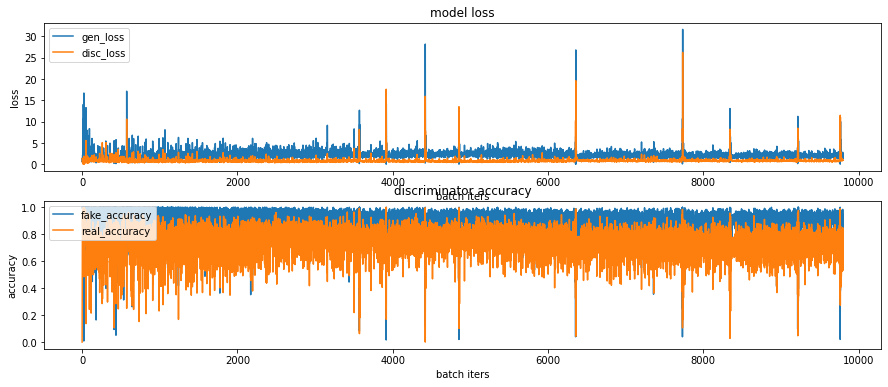

CPU times: user 35min 5s, sys: 1min 4s, total: 36min 9s
Wall time: 34min 47s


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

# 학습과정의 loss, accuracy 그래프 이미지 파일이 ~/aiffel/dcgan_newimage/fashion/training_history 경로에 생성

In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/second.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

In [ ]:
save_every = 5
EPOCHS = 75

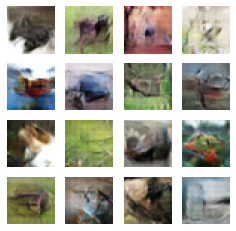

Epoch 57 | iter 151
Time for epoch 57 : 31 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

In [ ]:
anim_file = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/second.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('{}/aiffel/dcgan_newimage/cifar10/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/aiffel/dcgan_newimage/fashion/fashion_mnist_dcgan.gif

![second](https://user-images.githubusercontent.com/116326345/208458110-e4626dd4-6752-46c2-81ce-6db9ccac1c38.gif)




In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### STEP 8. (optional) GAN 훈련 과정 개선하기

In [ ]:
EPOCHS = 100

In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)

![300](https://user-images.githubusercontent.com/116326345/208542948-add487cd-7819-4a82-b3e1-2883fe6470be.png)



![3rd](https://user-images.githubusercontent.com/116326345/208542007-43c86d44-8ef5-4ae8-b98c-06948035db89.gif)


In [ ]:
checkpoint_dir = os.getenv('HOME')+'/aiffel/dcgan_newimage/cifar10/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

### 회고

#### 1. GAN 모델
:generator와 discriminator가 서로 발전하는 방향으로 학습을 시키고, 동반 성장하는 결과를 기대한다는 모델의 컨셉이 기가 막히다 생각했다. 마치 경찰과 도둑같다. 혹은 문제집 답지를 배끼는 아들과 그걸 알아채야만 하는 엄마의 관계 같기도 하다. 컨셉이 명확한 만큼 이해가 명확하게 가지는 않았지만, 재밌게 공부했다. 

#### 2. 판별자가 real output, fake output을 얼마나 정확히 판별하는지
:accuracy를 계산해 보는 것도 GAN의 학습에서 매우 중요하다는데 처음엔 잘 이해가 잘 가지않았다. 엔트로피 값을 왜 더하는지 등...  특히 두 accuracy를 따로 계산해서 비교해 보는 이유를 통해 나중에 깨닫게 되었다. 만약 판별자가 real output과 fake output을 accuracy가 1.0에 가까울 정도로 정확하게 판별해 낸다면 좋은 모델이 아니다. 이 경우 생성자가 만들어내는 fake output이 real output과 차이가 많이 나기 때문에 판별자가 매우 쉽게 판별해 내고 있다는 뜻이다. 모델을 돌려보면  real accuracy와 fake accuracy는 초반에는 1.0에 가깝게 나오다가, 서서히 낮아져서 둘 다 0.5에 가까워지려고 한다. fake accuracy가 1.0에 더 가깝다면 아직은 생성자가 판별자를 충분히 잘 속이지 못하고 있다는 뜻이다.

#### 3.학습양이 늘 수록 과연 점점 진화해서 좋은 모델이 될 수 있을까? 
:EPOCHS = 50, 75, 300으로 테스트 해보았다. 학습이 거듭될 수록 'real_accuracy'는 1에서 0.5에 가깝게 점점 가까워 졌고, 'fake_accuracy'의 수치는 1에 가까워진다. 보다 여러가지 가능성을 놓고 실험을 충분히 해보지는 못했지만, 그래프를 통해 0.5에 수치가 가까워 졌다면 좋은 모델에 가깝다고 이야기 할 수 있을 것 같다.학습시간이 길어 과제를 내는 시간에 맞추어 하이퍼 파라미터를 바꾸어서 테스트 해보지는 못했다. 추후 개인적으로 진행해 볼 예정이다. 
 
#### 4. 생성된 사진의 형태 
:흐릿해서 형체를 알아볼 수 없다가 학습이 거듭될수록 윤곽이 구체적으로 드러나 보인다. 점점 진짜와 같은 이미지를 만들기 위한 과정인 것 같다. 

#### 5. 손실함수의 필요성 로스값에 대해서 
: 앞서 공부했던 모델들은 일반적으로 로스값이 0-1사이로 세팅을 하지만 GAN 모델은 손실함수의 최재 최소가 0-2로 세팅이 된다. 훈련을 시키는 모델이 두개이다보니 두개를 더하나보다. 하고 가볍게 생각했었는데 생성자와 판별자의 게임의 과정중에 진짜 이미지를 생성하는 모델이기에 실제 이미지와 오차를 최소하 하기 위해 손실함수는 모델의 성능을 최적화를 위해 매우 중요하다.로그를 취하는데 간단한 수식을 만들어 두개의 최대최소를 따로 관리 할 수 있고, 또 계산하면 하나가 된다.로그는 따로 취해주면 두 모델의 합으로 따로 관리 되지만 계산할때는 곱으로 깔끔하게 계산이 가능하다는 장점을 여기서 활용하는것 같다.

#### 6. 과제를 했다는 것에 그치지 않고 조금은 이해하고 재미있게 했기에 나름 의미 있는 과제였다. 이미지를 만들어 판별자가 캡션을 달아주는 시스템을 만들어 보면 재밌을것 같다고 생각했다. 모델 학습을 덜 시키면 추상적인 이미지가 생성이 되서 그림을 그리는데 활용해도 좋을 것 같다. 또한 낡은 사진을 복원하거나 부분이미지로 전체이미지를 추정해 나갈 수 있는 시스템도 연구해보면 가능할 것 같다. 


### 레퍼런스 
https://koreascience.kr/article/CFKO201924664108422.pdf
https://zzcojoa.tistory.com/89